<center style="font-size: 16px; font-weight: normal">
  `21 Microservices Architecture Patterns Study</center>

<center><h1>Chapter 4. Our First Use Case:<br/> Flask API and Service Layer</h1></center>

<center>
  Joseph Kim &lt;cloudeyes@gmail.com&gt;<br/>
  Dec 28. 2020<br/>
</center>

<center>
  <img src="https://images-na.ssl-images-amazon.com/images/I/51-q9CWNBHL._SX379_BO1,204,203,200_.jpg" style="width: 200px">
</center>

<center>
  <a href="https://github.com/cloudeyes/2021-msa-study/blob/main/04-flask-api-and-service-layer/04-flask-api-and-service-layer.ipynb">Download Jupyter Notebook</a>
</center>

**참고자료**

Flask 배울때 참고하면 좋은 문서입니다.!
- [Explore Flask](https://exploreflask.com/en/latest/index.html)

# Introduction

In this chapter, we discuss:
- the differences between *orchestration logic*, *business logic*, and *interfacing code*.
- the *Service Layer pattern*
  - to take care of orchestrating our workflows
  - and defining the use cases of our system.
  
We'll also discuss "testing" again:
- by combining the Service Layer with our repository abstraction 


**Overal structure:**

<img src="./images/fig4-2.png" width="500px"/>

# Connecting Our Application to the Real World

**Strategy:**

1. Quickly make a MVP(Minimum-Valuable Product)
1. And then refactor toward a cleaner architecture.

**Steps:**

1. **Use Flask to put an API endpoint:** 
  - in front of our allocate domain service. 
  - wire up the database session and our repository. 
  - test it with an end-to-end test with quick-and-dirty test data.
1. **Refactor out a service layer:** 
  - can serve as an abstraction to capture the use case 
  - sits between Flask and our domain model. 
  - tests and show how they can use `FakeRepository`.
1. **Experiment with different types of parameters:** 
  - using primitive data types 
  - allows the service layer be decoupled from the model layer.

# A First End-to-End Test

- https://flask.palletsprojects.com/en/1.1.x/testing/

## 사전 준비

### 실습에 필요한 필수 패키지 설치하기

In [1]:
!pip install flask requests sqlalchemy pytest | grep "satisfied: flask"

### IDE(Visual Studio Code) 사용시 필요한 전체 패키지

In [2]:
!cat app/requirements.txt

# production
requests
sqlalchemy
flask
fastapi
fastalchemy

# development
pytest
pytest-flask
pydocstyle
git+https://github.com/AllanDaemon/mypy.git@0edf1233672117c4555759c5a91461a502ddce5d
git+https://github.com/PyCQA/pylint.git


### 디렉토리 구조

In [3]:
!tree app -v --dirsfirst -I "__pycache__"

app
├── adapters
│   ├── orm.py
│   └── repository.py
├── apps
│   ├── __init__.py
│   ├── fastapi.py
│   └── flask.py
├── domain
│   ├── __init__.py
│   └── models.py
├── routes
│   └── flask.py
├── services
│   ├── __init__.py
│   ├── _fail.py
│   └── batch.py
├── tests
│   ├── e2e
│   │   ├── __init__.py
│   │   └── test_flask_api.py
│   ├── func
│   ├── unit
│   │   ├── __init__.py
│   │   └── test_models.py
│   ├── __init__.py
│   └── conftest.py
├── __init__.py
├── __main__.py
├── config.py
└── requirements.txt

9 directories, 21 files


## E2E 테스트 구현해보기

### 실패하는 테스트 먼저 만들어보기

In [4]:
from app.tests import mytest

In [5]:
@mytest.test
def test_api_returns_allocation(add_stock):
    sku, othersku = random_sku(), random_sku('other')
    earlybatch = random_batchref(1)
    laterbatch = random_batchref(2)
    otherbatch = random_batchref(3)
    add_stock([
        (laterbatch, sku, 100, '2011-01-02'),
        (earlybatch, sku, 100, '2011-01-01'),
        (otherbatch, othersku, 100, None),
    ])
    data = {'orderid': random_orderid(), 'sku': sku, 'qty': 3}
    url = config.get_api_url()
    r = requests.post(f'{url}/allocate', json=data)
    assert r.status_code == 201
    assert r.json()['batchref'] == earlybatch

❌ test_api_returns_allocation


Traceback (most recent call last):
  File "/home/ykkim/notebooks/2021-msa-study/04-flask-api-and-service-layer/app/tests/__init__.py", line 38, in unwrap
    assert fixname in cls.modules, \
AssertionError: name "add_stock" should be registered first with @mytest.fixture


`add_stock` fixture가 없을 뿐 아니라 `requests.post` 함수가 접속할 flask 서버가 떠 있지 않기 때문에 당연히 실패하는 테스트입니다. 

테스트를 만들어 보니 어떤 일을 해야할지 대략적으로 감이 잡히는 것 같네요.

### 테스트가 성공하도록 해야 할일

테스트를 성공시키기 위해서 이런 작업을 해야 합니다.

1. **테스트 환경 만들기**
1. **테스트 헬퍼 함수 만들기**
    - `random_sku() -> str`
    - `random_batchref(eta_days: int) -> Batch`
    - `random_order_id() -> str`
1. **Fixture 만들기**
    - `add_stock` fixture 생성
1. **`e2e` 테스트용 Flask 서버 띄우기**
    - Flask 앱: `http://localhost:5000` 에서 서비스 합니다.
    - DB: PostgrSQL DB를 컨테이너에서 실행합니다.

### 1. 테스트 환경 만들기

#### 테스트용 DB 선정: PostgreSQL DB 

아래 그림처럼 버전과 패키징 방법에 따라 따라 컨테이너 이미지 크기 차이가 엄청납니다. 
- 12: ~109.72 (일반 Debian 리눅스 버전)
- 12-alpine: ~62MB (경량 Alpine 리눅스 버전)
- 11.10-alpine: ~60MB
- 10.15-alpline: ~28MB
- 9.6-alpine: ~14MB

저는 가장 가벼운 버전인 `9.6-apline` 이미지를 사용하겠습니다.

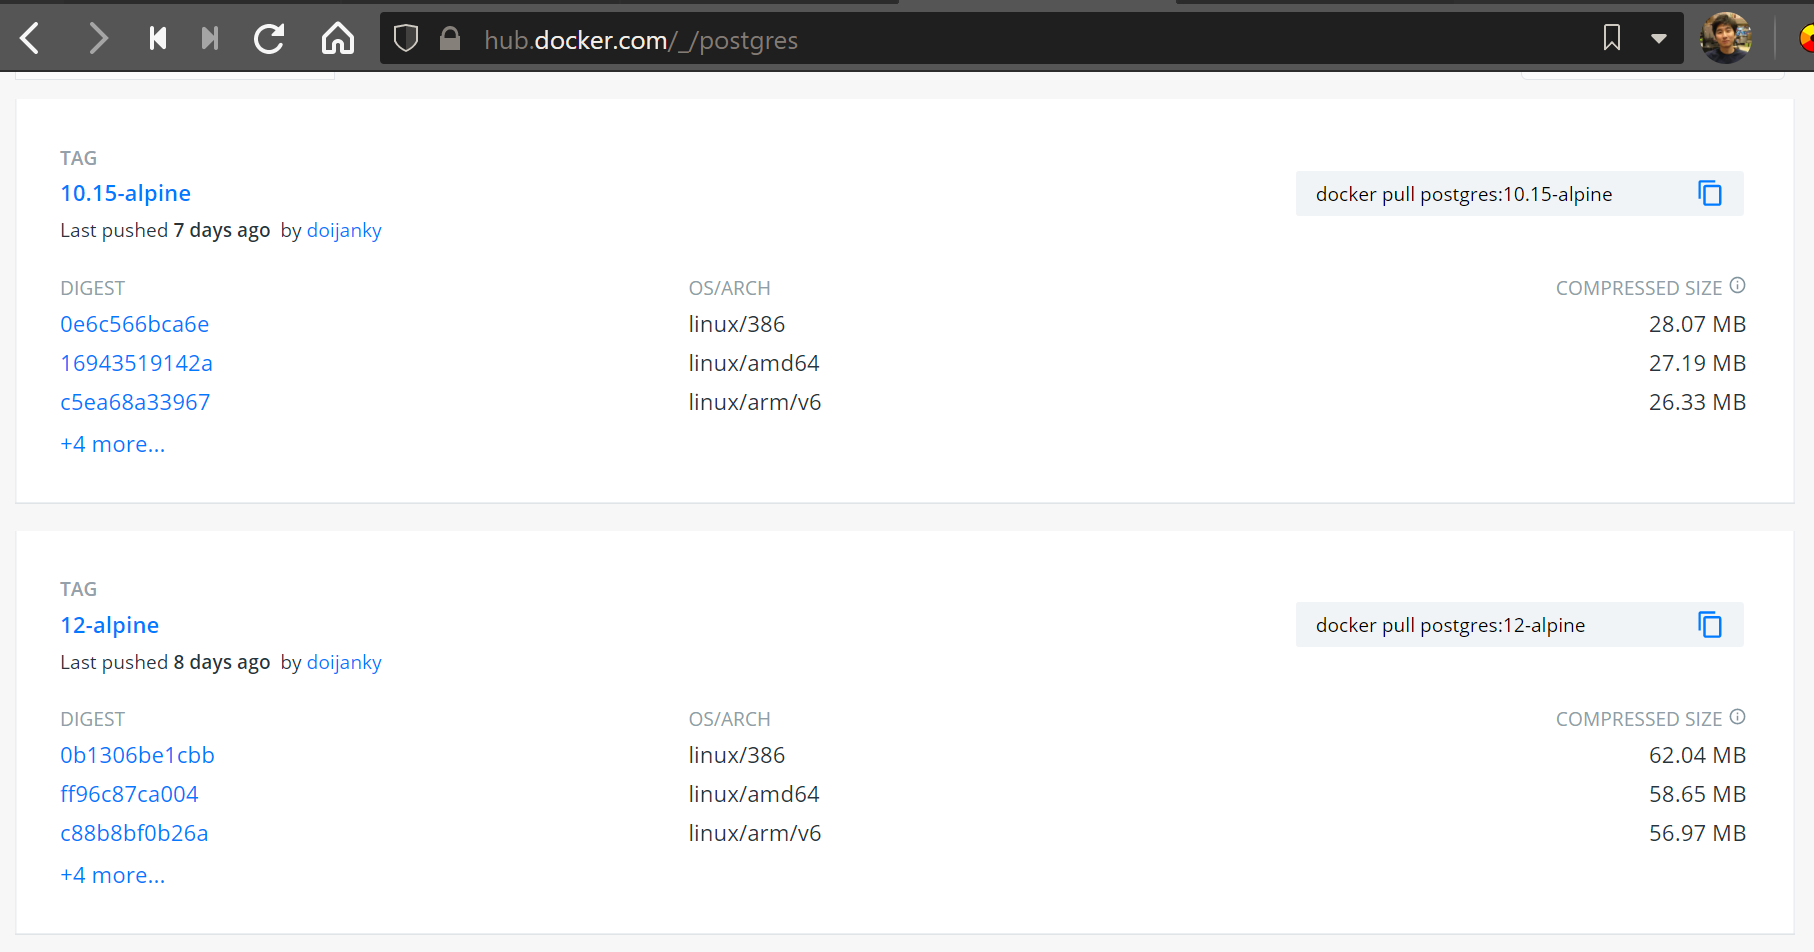

#### `docker-compose` 로 기존 개발 컨테이너에 DB 붙이기

기존에 사용하시던 `micropy-dev` 컨테이너 환경과 PostgreSQL DB를 연결할 것입니다.

`docker-compose.yml` 이라는 파일을 다음과 같이 만들어주세요.

In [6]:
!cat docker-compose.yml

version: "3"
services:
  app:
    image: cloudeyes/micropy-lab:3.9
    depends_on:
      - postgres
    environment:
      - DB_HOST=localhost
      - DB_PASSWORD=p@ssw0rd
    volumes:
      - ~/notebooks:/users/smprc/notebooks
    ports:
      - "5005:80"
      - "12222:22"
      - "18888:8888"

  postgres:
    image: postgres:9.6-alpine
    environment:
      - POSTGRES_USER=smprc
      - POSTGRES_PASSWORD=p@ssw0rd
    ports:
      - "5432:5432"


#### `docker-compose` 사용법 소개

- 참고문서: https://docs.docker.com/compose/gettingstarted

compose 된 컨테이너를 실행하기 위해서는 2가지 방법이 있습니다.
- `docker-compose up` : 컨테이너들이 포그라운드로 실행됨 (Ctrl+C 누르면 종료)
- `docker-compose up -d`: 데몬으로 실행하기

아래는 `docker-compose up` 을 처음 실행했을때 합성 컨테이너셋을 만드는 과정을 캡쳐한 것입니다.

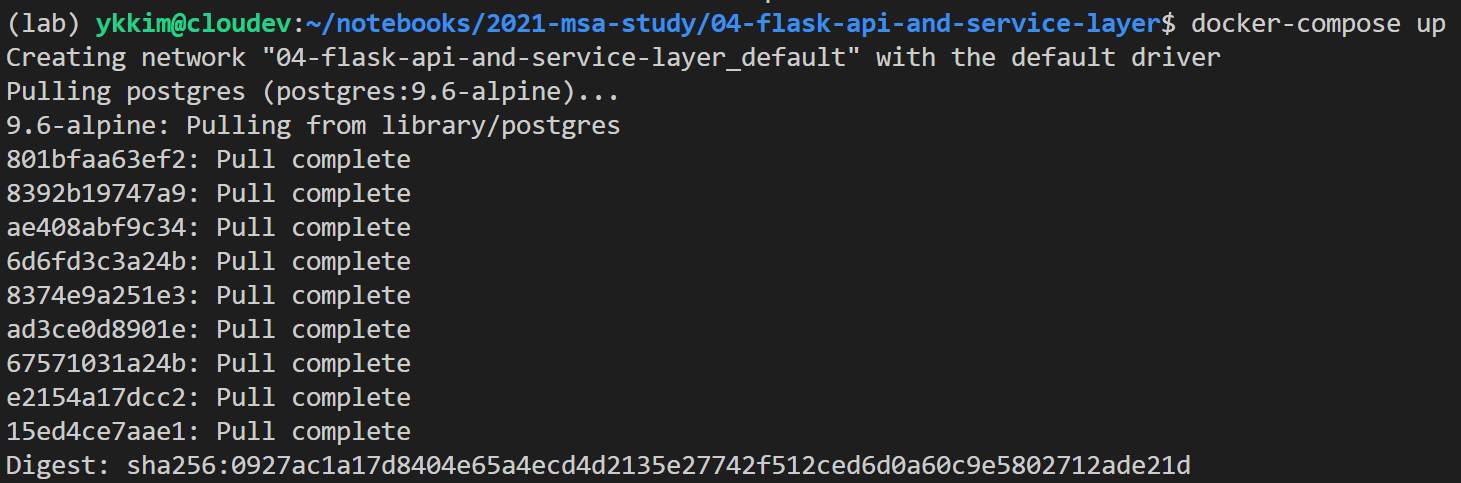

`docker-compose up -d` 명령으로 데몬으로 띄웠을 경우 `docker ps`와 유사한 `docker-compose ps` 명령어로 실행중인 합성 컨테이너들을 확인할 수 있습니다.

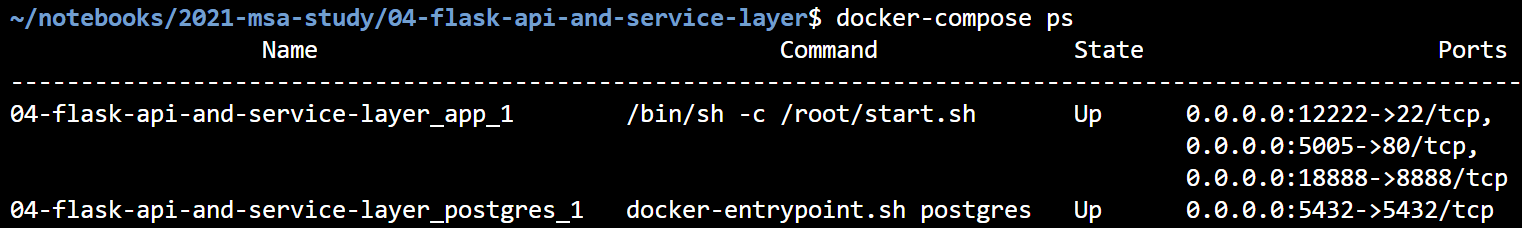

#### 합성된(composed) 컨테이너에서 PostgreSQL 테스트 해보기

> 1. **[주의]** 이 노트북을 합성 컨테이너에서 실행중인 Jupyter 서버에서 실행하셔야 합니다. 

먼저 PostgreSQL DB 접속을 위한 `psycopg2` 라이브러리를 설치합시다. 

C라이브러리가 컴파일되어 패키징된 `psycopg2-binary` 패키지가 있어서 `gcc` 등 빌드 도구가 없는 경량 컨테이너 환경에서도 쉽게 설치 가능합니다.

In [7]:
!pip install psycopg2-binary

`connect` 함수로 실제 DB에 접속해보겠습니다.

`docker-compose ps` 실행시 표시되는 이름이 결합된 컨테이너의 호스트명이 되고 각 컨테이너는 다른 컨테이너를 이 이름으로 접속할 수 있습니다. 

저의 경우는 `04-flask-api-and-service-layer_postgres_1` 라는 이름이 PostgreSQL DB 컨테이너의 호스트명이 되었습니다.

In [8]:
import psycopg2
pg_host = '04-flask-api-and-service-layer_postgres_1'
conn = psycopg2.connect(f"dbname='smprc' user='smprc'  password='p@ssw0rd' host='{pg_host}'")

쿼리 결과를 받아오는 예제입니다. Python 표준 DB API 프로토콜을 준수하기 때문에 다른 DB 클라이언트 라이브러리(`cx_Oracle`, `mysqlclient` 등)와 사용법이 동일합니다.

In [9]:
cur = conn.cursor()
cur.execute("""SELECT datname from pg_database""")
rows = cur.fetchall()
rows

[('postgres',), ('smprc',), ('template1',), ('template0',)]

#### PostgresSQL 에 ORM Mapper 적용해보기

Python ORM Mapper를 이용한 PostreSQL DB 데이터 조회 방법입니다.

In [10]:
from flask import Flask, jsonify, request
from sqlalchemy.orm import sessionmaker

from app.adapters import orm, repository
from app.adapters.orm import SqlAlchemyRepository

orm.clear_mappers()
metadata = orm.start_mappers(use_exist=False)
pg_host = '04-flask-api-and-service-layer_postgres_1'
db_url = f"postgres+psycopg2://smprc:p%40ssw0rd@{pg_host}/smprc"
engine = orm.init_engine(metadata, db_url, drop_all=True, show_log=True)

# engine 을 이용한 SQL 실행 
engine.execute('SELECT * FROM batch').fetchall()

CREATE TABLE order_line (
	id SERIAL NOT NULL, 
	sku VARCHAR(255), 
	qty INTEGER NOT NULL, 
	orderid VARCHAR(255), 
	PRIMARY KEY (id)
)

CREATE TABLE batch (
	id SERIAL NOT NULL, 
	reference VARCHAR(255), 
	_purchased_quantity INTEGER, 
	sku VARCHAR(255), 
	eta DATE, 
	PRIMARY KEY (id), 
	UNIQUE (reference)
)

CREATE TABLE allocation (
	orderline_id INTEGER NOT NULL, 
	batch_id INTEGER NOT NULL, 
	PRIMARY KEY (orderline_id, batch_id), 
	FOREIGN KEY(orderline_id) REFERENCES order_line (id), 
	FOREIGN KEY(batch_id) REFERENCES batch (id)
)




[]

[contextmanager](https://docs.python.org/3/library/contextlib.html#contextlib.contextmanager) 를 이용해 자동으로 세션 리소스를 해제하는 헬퍼 함수를 만들어봅시다.

In [11]:
from contextlib import contextmanager
get_session = sessionmaker(engine)

@contextmanager
def scoped_session():
    session = None
    try:
        yield (session := get_session())
    finally:
        session and session.close()
        
from app.domain.models import Batch
with scoped_session() as db:
    assert [] == db.query(Batch).all()

#### PostgresSQL DB `SqlAlchemyRepository` 사용해보기

제가 확장한 `AbstractRepository` 에는 자동 리소스 반환 프로토콜이 내장되어 있습니다. 아래와 같이 자동 리소스 반환되는 `with` 블록에서 Repository 인스턴스를 사용할 수 있습니다.

In [12]:
with SqlAlchemyRepository(get_session()) as repo:
    assert [] == repo.list()

### 2. 테스트 헬퍼 함수 만들기

[RFC 4122](https://tools.ietf.org/html/rfc4122.html) UUID(Universally Unique IDentifier)를 이용해 완전한 랜덤을 보장하는 ID를
생성할 수 있습니다.

- [Is Python uuid.uuid4 strong enough for password reset links?](https://stackoverflow.com/questions/41505448/is-python-uuid-uuid4-strong-enough-for-password-reset-links#:~:text=2%20Answers&text=Yes,%20a%20UUID4%20is%20fully,randomness%20you%20should%20be%20fine)

#### `uuid` 모듈 사용해보기

In [13]:
import uuid
uuid.uuid4()

UUID('e7db4038-adfb-4634-b55a-555a9badcb77')

In [14]:
uuid.uuid4().hex

'94f0532f4c1847b5a95fb419c7029184'

#### uuid를 이용한 `random_*` 테스트 헬퍼 함수 구현하기

In [15]:
import uuid
def random_suffix():
    return uuid.uuid4().hex[:6]

def random_sku(name=''):
    return f'sku-{name}-{random_suffix()}'

def random_batchref(name=''):
    return f'batch-{name}-{random_suffix()}'

def random_orderid(name=''):
    return f'order-{name}-{random_suffix()}'

### 3. Fixture 만들기

#### `add_stock`, `get_repo` fixture 만들기

저자의 코드에서는 `postgres_session` 을 받아 PostgreSQL 에 종속된
테스트를 만들고 있는데, 왜 그러는지 의문입니다.

프로덕션용 `Repository`를 이용하는것이 여러 DB에서의 테스트를 고려할 때
훨씬 더 유연한 방식이기 때문에 (심지어 실제 서비스 구현도 Repository사용)
저는 Repository를 이용한 fixture 로 변경했습니다. 

In [16]:
from datetime import datetime
from app.tests import mytest
from app.domain.models import Batch

@mytest.fixture
def get_repo() -> SqlAlchemyRepository:
    return lambda: SqlAlchemyRepository(get_session())
            
@mytest.fixture
def add_stock(get_repo):
    batches_added = set[Batch]()
    with get_repo() as repo:
        def inner(lines: [tuple[str, str, int, str]]) -> None:
            for ref, sku, qty, eta in lines:
                eta = datetime.strptime(eta, '%Y-%m-%d') if eta else None
                batch = Batch(ref, sku, qty, eta)
                repo.add(batch)
                batches_added.add(batch)

        yield inner

        # Fixture 사용 이후 clean up 코드
        for batch in batches_added:
            lines = list(batch._allocations)
            batch._allocations.clear()
            for line in lines:
                repo.delete(line)
            repo.delete(batch)

        return inner

In [17]:
@mytest.test
def test_add_stock(add_stock, get_repo):
    sku, othersku = random_sku(), random_sku('other')
    earlybatch = random_batchref(1)
    laterbatch = random_batchref(2)
    otherbatch = random_batchref(3)
    add_stock([
        (laterbatch, sku, 100, '2011-01-02'),
        (earlybatch, sku, 100, '2011-01-01'),
        (otherbatch, othersku, 100, None),
    ])
    
    with get_repo() as repo:
        assert {earlybatch, laterbatch, otherbatch} == {it.reference for it in repo.list()}

# 테스트 후에 잘 cleanup 되었는지 확인
assert [] == engine.execute('SELECT * FROM batch').fetchall()

✅ test_add_stock


In [18]:
mytest.run(test_add_stock)

✅ test_add_stock


### 4. `ServerThread`: Jupyter 노트북용 Flask 앱 띄우기

Flask API 서버와 E2E 테스트를 위해 실제 서버가 백그라운드에서 구동되어야 합니다.

Jupyter 노트북에서는 셀에서 실행 명령을 누를때만 실행되기 구조라서 때문에 백그라운드 실행을 위해서 API 서버를 실행할 서버 스레드를 등록해야 합니다.

다음은 restart 가능한 `ServerThread` 구현입니다.

In [19]:
import threading
from werkzeug.serving import make_server
from app import config

class ServerThread(threading.Thread):
    def __init__(self, app):
        threading.Thread.__init__(self)
        self.srv = make_server(config.get_api_host(), config.get_api_port(), app)
        self.ctx = app.app_context()
        self.ctx.push()

    def run(self):
        print('starting server... ', end='')
        self.srv.serve_forever()

    def shutdown(self):
        print('shutting down server...')
        self.srv.shutdown()

def start_server(app):
    global server
    server = ServerThread(app)
    server.start()
    print('started.')

def stop_server():
    server = globals().get('server')
    server and server.shutdown()
    
def restart_server(app):
    stop_server()
    start_server(app)

Flask 에서 동일 endpoint에 라우팅 함수를 다시 정의 하려고 하면 에러가 발생 합니다. 
일반적인 상황에서는 사용자 실수를 방지하기 위한 올바를 Fool-Proof이지만, 인터렉티브 환경에서 
반복적으로 구현을 고치며 다양한 실험을 하기에는 불편하기 때문에 이런 제약을 없애도록 패치했습니다.

In [20]:
from flask import Flask
class CustomFlask(Flask):
    """동일 endpoint에 라우팅을 덮어쓰도록 허용하는 커스텀 Flask 구현입니다."""
    
    def add_url_rule(self, rule, 
                     endpoint=None, view_func=None, 
                     provide_automatic_options=None, **options):
        # 기존 매핑을 제거 후 등록합니다.
        self.view_functions.pop(view_func.__name__, None)
        Flask.add_url_rule(self, rule, 
                           endpoint=endpoint, view_func=view_func,
                           provide_automatic_options=provide_automatic_options,
                           **options)        

#### 엔드포인트 만들어 보기

그럼 이 테스트용 `ServerThread` 와 `CustomFlask` 를 어떻게 사용하는지 알아보겠습니다. 


먼저 `test_app`을 하나 생성하고, 이 앱에 대한 `route` 데코레이터를 정의합니다.

In [21]:
test_app = CustomFlask('test_app')
route = test_app.route

`POST /allocate` 엔드포인트를 만들어봅시다. 요청(request) 파라메터를 그대로 출력한 뒤 `501`(서버 에러: Not Implemented) 상태코드를 리턴하는 깡통 구현입니다. 

이 라우팅 핸들러를 반영하기 위해서는 `restart_server` 함수를 호출하여 Flask App을 재시작해야 합니다.

**참고:** [HTTP 상태코드 레퍼런스](http://www.iana.org/assignments/http-status-codes/http-status-codes.xhtml)

In [22]:
from flask import request, jsonify

@route('/allocate', methods=['POST'])
def allocate_endpoint():
    print(f'{request.json=}')
    return jsonify({}), 501

restart_server(test_app) # 라우팅 적용을 서버에 업데이트 하기 위해서는 Restart 필요

starting server... started.


#### `requests` 로 엔드포인트 테스트 해보기

`requests` 라이브러리를 이용해 엔드포인트에 요청을 보내 보겠습니다. 

사용법이 워낙 직관적이라 별도의 설명은 필요없을 듯 합니다.

In [23]:
import requests
res = requests.post(f'{config.get_api_url()}/allocate', json={
    'hello': 'world'
})
assert 501 == res.status_code 

127.0.0.1 - - [08/Jan/2021 20:45:28] "POST /allocate HTTP/1.1" 501 -


request.json={'hello': 'world'}


#### 첫 번째 API 테스트 

In [24]:
from app.tests import mytest

@mytest.test
def test_api_returns_allocation(add_stock, get_repo):
    from app import config
    import requests
    
    sku, othersku = random_sku(), random_sku('other')
    earlybatch = random_batchref(1)
    laterbatch = random_batchref(2)
    otherbatch = random_batchref(3)
    add_stock([
        (laterbatch, sku, 100, '2011-01-02'),
        (earlybatch, sku, 100, '2011-01-01'),
        (otherbatch, othersku, 100, None),
    ])
    data = {'orderid': random_orderid(), 'sku': sku, 'qty': 3}
    url = config.get_api_url()
    r = requests.post(f'{url}/allocate', json=data)
    assert r.status_code == 201
    assert r.json()['batchref'] == earlybatch
    
    return earlybatch

127.0.0.1 - - [08/Jan/2021 20:45:28] "POST /allocate HTTP/1.1" 501 -


request.json={'orderid': 'order--7339da', 'sku': 'sku--224041', 'qty': 3}
❌ test_api_returns_allocation


Traceback (most recent call last):
  File "<ipython-input-24-ee04117d4e65>", line 20, in test_api_returns_allocation
    assert r.status_code == 201
AssertionError


# The Straightforward Implementation

가장 단순하고 직접적인 엔트포인트 구현입니다.

In [25]:
from flask import Flask, jsonify, request
from app.adapters.orm import get_scoped_session
scoped_session = get_scoped_session(engine)

In [26]:
@route("/allocate", methods=['POST'])
def allocate_endpoint():
    from app.domain import models
    with scoped_session() as db:
        repo = SqlAlchemyRepository(db)
        batches = repo.list()
        line = models.OrderLine(
            request.json['orderid'],
            request.json['sku'],
            request.json['qty'],
        )
        batchref = models.allocate(line, batches)
    return jsonify({'batchref': batchref}), 201
    
restart_server(test_app)

shutting down server...
starting server... started.


엔드 포인트 수정후 아래와 같이 테스트를 돌려봅시다. 테스트가 성공했습니다!

In [27]:
mytest.run(test_api_returns_allocation)

127.0.0.1 - - [08/Jan/2021 20:45:28] "POST /allocate HTTP/1.1" 201 -


✅ test_api_returns_allocation


그럼 E2E 테스트로 DB 테이블 값들이 어떻게 바뀌었는지 살펴볼까요?

In [28]:
with scoped_session() as db:
    batches = db.execute('SELECT * FROM batch').fetchall()
    lines = db.execute('SELECT * FROM order_line').fetchall()
    allocs = db.execute('SELECT * FROM allocation').fetchall()
    print(f'{batches=}, {lines=}, {allocs=}')

batches=[], lines=[], allocs=[]


이상하게 아무 값도 없습니다. 사실 이상한게 아니라 각 테스트는 특별한 이유가 없는 이상 DB에 부수 효과(side-effect)를 주지 말아야 합니다. 아까 `add_stock` Fixture 를 정의할 때 아래와 같은 cleanup 코드가 있었음을 기억하세요.
```python
        ...

        yield inner

        # Fixture 사용 이후 clean up 코드
        for batch in batches_added:
            repo.delete(batch)

        return inner
```

`/allocate` 요청 결과가 실제 DB에 반영되었는지를 확인하려면 아래와 같이 테스트 코드를 수정해야 합니다.

In [29]:
@mytest.test
def test_api_returns_allocation_debug(add_stock, get_repo):
    earlybatch = test_api_returns_allocation(add_stock, get_repo)
    
    with scoped_session() as db:
        batch = db.query(Batch).filter_by(reference=earlybatch).first()
        lines = db.execute("SELECT * FROM order_line").fetchall()
        allocs = db.execute("SELECT * FROM allocation").fetchall()
        print(f'{batch=}, {lines=}, {allocs=}, {batch._allocations=}')

127.0.0.1 - - [08/Jan/2021 20:45:28] "POST /allocate HTTP/1.1" 201 -


batch=<app.domain.models.Batch object at 0x7f9988ee66d0>, lines=[], allocs=[], batch._allocations=InstrumentedSet()
✅ test_api_returns_allocation_debug


실제로 `allocation` 테이블와 `order_line` 테이블에 반영된 데이터가 포함되지 않았음을 확인할 수 있습니다. 도대체 이유가 뭘까요?

이유는 간단합니다.`allocate_endpoint` 에서 `models.allocate()` 호출 이후에 `db.commit()` 을 실행하지 않았기 때문입니다.

테스트가 실패했어야 하는데 성공했으므로 문제가 있습니다. 실패하도록 테스트를 고쳐보겠습니다.

In [30]:
@mytest.test
def test_allocations_are_persisted(add_stock):
    sku = random_sku()
    batch1, batch2 = random_batchref(1), random_batchref(2)
    order1, order2 = random_orderid(1), random_orderid(2)
    add_stock([
        (batch1, sku, 10, '2021-01-01'),
        (batch2, sku, 10, '2021-01-02'),
    ])
    line1 = {'orderid': order1, 'sku': sku, 'qty': 10}
    line2 = {'orderid': order2, 'sku': sku, 'qty': 10}
    url = config.get_api_url()
    
    # 첫번째 주문으로 batch1 이 소진되어야 합니다.
    r = requests.post(f'{url}/allocate', json=line1)
    assert 201 == r.status_code
    assert batch1 == r.json()['batchref']
    
    # 두번째 주문으로 batch2 가 소진되어야 합니다.
    r = requests.post(f'{url}/allocate', json=line2)
    assert 201 == r.status_code
    assert batch2 == r.json()['batchref']    

127.0.0.1 - - [08/Jan/2021 20:45:28] "POST /allocate HTTP/1.1" 201 -
127.0.0.1 - - [08/Jan/2021 20:45:28] "POST /allocate HTTP/1.1" 201 -


❌ test_allocations_are_persisted


Traceback (most recent call last):
  File "<ipython-input-30-c6d0e8ffd5aa>", line 22, in test_allocations_are_persisted
    assert batch2 == r.json()['batchref']
AssertionError


테스트가 잘 실패(?)합니다. 이제 테스트가 성공하도록 `allocate_endpoint` 를 수정해봅시다. 

In [31]:
@route("/allocate", methods=['POST'])
def allocate_endpoint():
    from app.domain import models
    with scoped_session() as db:
        repo = SqlAlchemyRepository(db)
        batches = repo.list()
        line = models.OrderLine(
            request.json['orderid'],
            request.json['sku'],
            request.json['qty'],
        )
        batchref = models.allocate(line, batches)
        db.commit() # DB에 변경 사항을 반영합니다.
    return jsonify({'batchref': batchref}), 201
    
restart_server(test_app)

shutting down server...
starting server... started.


수정 후에는 테스트가 잘 성공합니다. :D 

In [32]:
mytest.run(test_allocations_are_persisted)

127.0.0.1 - - [08/Jan/2021 20:45:29] "POST /allocate HTTP/1.1" 201 -
127.0.0.1 - - [08/Jan/2021 20:45:29] "POST /allocate HTTP/1.1" 201 -


✅ test_allocations_are_persisted


# Error Conditions That Require Database Checks

그런데 위와 같은 방식으로 DB Validation 체크를 하면 코드 품질은 점점 나빠집니다.

- 레포지터리나 ORM, DB 문제로 에러가 발생할 경우
- OutOfStock 인 SKU일 경우, SKU가 없을 경우

등 DB나 ORM단에서 발생 가능한 수많은 예외 상황을 고려하다 덕지 덕지 추가되는 테스트 코드 때문에 테스트 필요한 핵심 비즈니스 로직이 가려지기 때문입니다.

아래는 서비스가 예외 상황을 올바르게 처리하는지를 체크하는 예제 테스트입니다. 현재 구현된 서비스에는 예외 처리 코드가 없으므로 테스트는 당연히 실패합니다.

In [33]:
test_app.logger.disabled = True # 서버 예외가 Jupyter Notebook에 출력되지 않도록

@mytest.test
def test_400_message_for_out_of_stock(add_stock):
    """재고 보다 더 많은 양을 할당할 때 에러 발생하는지 테스트."""
    sku, small_batch, large_order = \
        random_sku(), random_batchref(), random_orderid()
    add_stock([
        (small_batch, sku, 10, '2021-01-01')
    ])
    data = {'orderid': large_order, 'sku': sku, 'qty': 20}
    url = config.get_api_url()
    r = requests.post(f'{url}/allocate', json=data)
    assert 400 == r.status_code
    assert f'Out of stock for sku {sku}' == r.json()['message']
        
@mytest.test
def test_400_message_for_invalid_sku():  
    """존재하지 않는 SKU를 할당할 때 에러가 발생하는지 테스트"""
    unknown_sku, orderid = random_sku(), random_orderid()
    data = {'orderid': orderid, 'sku': unknown_sku, 'qty': 20}
    url = config.get_api_url()
    r = requests.post(f'{url}/allocate', json=data)
    assert r.status_code == 400
    assert r.json()['message'] == f'Invalid sku {unknown_sku}'

127.0.0.1 - - [08/Jan/2021 20:45:29] "POST /allocate HTTP/1.1" 500 -


❌ test_400_message_for_out_of_stock


Traceback (most recent call last):
  File "<ipython-input-33-cc008ae5764d>", line 14, in test_400_message_for_out_of_stock
    assert 400 == r.status_code
AssertionError
127.0.0.1 - - [08/Jan/2021 20:45:29] "POST /allocate HTTP/1.1" 500 -


❌ test_400_message_for_invalid_sku


Traceback (most recent call last):
  File "<ipython-input-33-cc008ae5764d>", line 24, in test_400_message_for_invalid_sku
    assert r.status_code == 400
AssertionError


테스트가 성공하도록 엔드포인트를 개선해봅시다.

In [34]:
test_app.logger.disabled = False

def is_valid_sku(sku, batches):
    return sku in {b.sku for b in batches}

@route("/allocate", methods=['POST'])
def allocate_endpoint():
    from app.domain import models
    with scoped_session() as db:
        repo = SqlAlchemyRepository(db)
        batches = repo.list()
        line = models.OrderLine(
            request.json['orderid'],
            request.json['sku'],
            request.json['qty'],
        )

        if not is_valid_sku(line.sku, batches):
            return jsonify({'message': f'Invalid sku {line.sku}'}), 400

        try:
            batchref = models.allocate(line, batches)
        except models.OutOfStock as e:
            return jsonify({'message': str(e)}), 400
        
        db.commit()
        return jsonify({'batchref': batchref}), 201

restart_server(test_app)

shutting down server...
starting server... started.


In [35]:
mytest.run(test_400_message_for_out_of_stock)
mytest.run(test_400_message_for_invalid_sku)

127.0.0.1 - - [08/Jan/2021 20:45:29] "POST /allocate HTTP/1.1" 400 -


✅ test_400_message_for_out_of_stock


127.0.0.1 - - [08/Jan/2021 20:45:30] "POST /allocate HTTP/1.1" 400 -


✅ test_400_message_for_invalid_sku


테스트는 성공했지만 서비스 구현 코드가 예외 처리로 인해 지저분해졌습니다. E2E 테스트의 숫자도 통제 불능으로 숫자가 증가하게 되었습니다.

어떻게 이런 문제를 해결할 수 있을까요?

# Introducing a Service Layer, and Using `FakeRepository` to Unit Test It

지금까지 구현한 서비스 엔드포인트에는 애플리케이션상의 다양양 컴포넌트들을 세밀하게 조정하는(오케스트레이션) 과정들이 있습니다.

- 레포지터리에서 데이터 얻기
- DB 상태에 대한 입력값 유효성 검사
- 에러 처리
- 올바른 처리 후 DB 커밋


그런데, 이 중 대부분은 웹 API 엔드포인트의 구현 로직과 관련이 없으며, E2E 테스트에 포함될 필요가 없습니다.

즉, 오케스트레이션에 관련된 부분을 분리해서 "서비스 레이어" 로 분리할 필요가 있습니다.
(이 서비스 레이어를 "오케스트레이션 계층" 또는 "유즈 케이스 계층" 으로 부르기도 합니다.)

DB 상태나 파일 시스템 등 서비스와 관련 없는 부분에 영향받지 않는 테스트를 위해 `FakeRepository` 로 레포지터리를 대체해봅시다.

In [36]:
from typing import Optional
from app.adapters.repository import AbstractRepository
from app.domain.models import Batch

class FakeRepository(AbstractRepository):
    
    def __init__(self, batches):
        self._batches = set(batches)

    def add(self, batch: Batch) -> None:
        self._batches.add(batch)

    def get(self, reference: str) -> Optional[Batch]:
        return next(b for b in self._batches if b.reference == reference)

    def list(self) -> list[Batch]:
        return list(self._batches)

    def delete(self, batch: Batch) -> None:
        self._batches.delete(model)
    
    def clear(self):
        self._batches.clear()

    def close(self) -> None:
        pass

이 페이크 레포지터리로 서비스 레이어의 기능 동작을 테스트를 통해 완성해 봅시다. 먼저 실패하는 "빠른 단위 테스트"(fast unit test) 를 만들어 봅시다.

In [37]:
from app.tests import mytest
from app.domain import models
from app.services import _fail as services # 실패하는 서비스
import pytest

@mytest.test
def test_returns_allocation():
    line = models.OrderLine("o1", "COMPLICATED-LAMP", 10)
    batch = models.Batch("b1", "COMPLICATED-LAMP", 100, eta=None)
    repo = FakeRepository([batch])  

    result = services.allocate(line, repo, FakeSession())  
    assert result == "b1"

@mytest.test
def test_error_for_invalid_sku():
    line = models.OrderLine("o1", "NONEXISTENTSKU", 10)
    batch = models.Batch("b1", "AREALSKU", 100, eta=None)
    repo = FakeRepository([batch])  

    with pytest.raises(services.InvalidSku, match="Invalid sku NONEXISTENTSKU"):
        services.allocate(line, repo, FakeSession())

❌ test_returns_allocation


Traceback (most recent call last):
  File "<ipython-input-37-86150bf828ce>", line 12, in test_returns_allocation
    result = services.allocate(line, repo, FakeSession())
AttributeError: module 'app.services._fail' has no attribute 'allocate'


❌ test_error_for_invalid_sku


Traceback (most recent call last):
  File "<ipython-input-37-86150bf828ce>", line 21, in test_error_for_invalid_sku
    with pytest.raises(services.InvalidSku, match="Invalid sku NONEXISTENTSKU"):
AttributeError: module 'app.services._fail' has no attribute 'InvalidSku'


테스트를 성공하기 위해서 해야 할 작업이 보입니다.

1. `services.allocate` 함수 구현하기
    - `FakeSession` 으로 가짜 세션 작업 흉내내기
2. `InvalidSku` 예외 객체 만들기

`FakeSession` 을 다음과 같이 구현하고 `commit` 작업에 대한 테스트를 추가해봅시다.

In [38]:
class FakeSession():
    committed = False

    def commit(self):
        self.committed = True
        
@mytest.test
def test_commits():
    line = models.OrderLine('o1', 'OMINOUS-MIRROR', 10)
    batch = models.Batch('b1', 'OMINOUS-MIRROR', 100, eta=None)
    repo = FakeRepository([batch])
    session = FakeSession()

    services.batch.allocate(line, repo, session)
    assert session.committed is True

❌ test_commits


Traceback (most recent call last):
  File "<ipython-input-38-e6e46a4cf603>", line 14, in test_commits
    services.batch.allocate(line, repo, session)
AttributeError: module 'app.services._fail' has no attribute 'batch'


## A Typical Service Function

테스트가 성공하도록 에러를 고쳐봅시다. 전형적인 서비스 레이어는 일반적으로 다음과 같은 단계를 포함합니다.

1. 레포지터리에서 서비스에 필요한 객체를 가져옵니다.
1. 애플리케이션 상태와 비교해 요청에 대한 유효성이나 정합성을 확인합니다.
1. 정상적인 요청이라면 도메인 서비스를 호출합니다.
1. 잘 동작한다면 변경 사항을 저장하거나 업데이트 합니다.

In [39]:
from app.adapters.orm import AbstractSession

class InvalidSku(Exception):
    pass

def is_valid_sku(sku, batches):
    return sku in {b.sku for b in batches}

def allocate(line: models.OrderLine, repo: AbstractRepository, session: AbstractSession) -> str:
    batches = repo.list()
    if not is_valid_sku(line.sku, batches):
        raise InvalidSku(f'Invalid sku {line.sku}')
    batchref = models.allocate(line, batches)
    session.commit()
    return batchref

In [40]:
@mytest.test
def test_returns_allocation():
    line = models.OrderLine("o1", "COMPLICATED-LAMP", 10)
    batch = models.Batch("b1", "COMPLICATED-LAMP", 100, eta=None)
    repo = FakeRepository([batch])  

    result = allocate(line, repo, FakeSession())  
    assert result == "b1"

@mytest.test
def test_error_for_invalid_sku():
    line = models.OrderLine("o1", "NONEXISTENTSKU", 10)
    batch = models.Batch("b1", "AREALSKU", 100, eta=None)
    repo = FakeRepository([batch])  

    with pytest.raises(InvalidSku, match="Invalid sku NONEXISTENTSKU"):
        allocate(line, repo, FakeSession())  

✅ test_returns_allocation
✅ test_error_for_invalid_sku


테스트가 잘 수행되었지만 한 가지 **아쉬운 점**이 있습니다. `session.commit` 이라는 명령이 포함되었기 때문입니다. 서비스 레이어가 DB구현과 강하게 결합되어 있는 이 문제를 나중에 6장의 "Unit of Work" 패턴에서 개선해 보겠습니다.

이제 엔드포인트를 다시 리팩토링해볼 차례입니다. `allocate_endpoint` 를 서비스 레이어를 이용하도록 고쳐봅시다.

In [41]:
from app import services

@route("/allocate", methods=['POST'])
def allocate_endpoint():
    with scoped_session() as session:
        repo = SqlAlchemyRepository(session)  
        line = models.OrderLine(
            request.json['orderid'],  
            request.json['sku'],  
            request.json['qty'],  
        )
        try:
            batchref = services.batch.allocate(line, repo, session)  
        except (models.OutOfStock, services.batch.InvalidSku) as e:
            return jsonify({'message': str(e)}), 400  

        return jsonify({'batchref': batchref}), 201  
    
restart_server(test_app)

shutting down server...
starting server... started.


이제 Flask 앱의 엔드포인트에서 하는 일이 웹 작업으로 깔끔하게 분리되었습니다. 

- POST 요청에서 JSON 데이터를 파싱하여 서비스 레이어의 입력으로 변환하는 작업
- HTTP 상태 코드를 반환하는 작업

그 외 실제 작업과 예외처리 같은  오케스트레이션 작업이 서비스 레이어와 레포지터리(모델) 레이어에서 담당하도록 위임되었습니다.

이제 엔드포인트와 완전히 분리된 서비스 레이어 테스트를 만들 수 있습니다! :D

In [42]:
# 서비스 레이어 전용 테스트
import app.services.batch

@mytest.test
def test_returns_allocation():
    line = models.OrderLine("o1", "COMPLICATED-LAMP", 10)
    batch = models.Batch("b1", "COMPLICATED-LAMP", 100, eta=None)
    repo = FakeRepository([batch])  

    result = services.batch.allocate(line, repo, FakeSession())  
    assert result == "b1"

@mytest.test
def test_error_for_invalid_sku():
    line = models.OrderLine("o1", "NONEXISTENTSKU", 10)
    batch = models.Batch("b1", "AREALSKU", 100, eta=None)
    repo = FakeRepository([batch])  

    with pytest.raises(services.batch.InvalidSku, match="Invalid sku NONEXISTENTSKU"):
        services.batch.allocate(line, repo, FakeSession())
        
        
@mytest.test
def test_commits():
    line = models.OrderLine('o1', 'OMINOUS-MIRROR', 10)
    batch = models.Batch('b1', 'OMINOUS-MIRROR', 100, eta=None)
    repo = FakeRepository([batch])
    session = FakeSession()

    services.batch.allocate(line, repo, session)
    assert session.committed is True        

✅ test_returns_allocation
✅ test_error_for_invalid_sku
✅ test_commits


마지막으로, 앞에서 만든 여러 E2E 테스트들을 **정상 케이스**와 **에러 케이스** 두 가지에 대한 E2E 테스트로 깔끔하게 줄일 수 있습니다.

In [43]:
test_app.logger.disabled = False

@mytest.test
def test_happy_path_returns_201_and_allocated_batch(add_stock):
    sku, othersku = random_sku(), random_sku('other')
    earlybatch = random_batchref(1)
    laterbatch = random_batchref(2)
    otherbatch = random_batchref(3)
    add_stock([
        (laterbatch, sku, 100, '2011-01-02'),
        (earlybatch, sku, 100, '2011-01-01'),
        (otherbatch, othersku, 100, None),
    ])
    data = {'orderid': random_orderid(), 'sku': sku, 'qty': 3}
    url = config.get_api_url()
    r = requests.post(f'{url}/allocate', json=data)
    assert 201 == r.status_code, f'{r.status_code}'
    assert earlybatch == r.json()['batchref']


@mytest.test
def test_unhappy_path_returns_400_and_error_message():
    unknown_sku, orderid = random_sku(), random_orderid()
    data = {'orderid': orderid, 'sku': unknown_sku, 'qty': 20}
    url = config.get_api_url()
    r = requests.post(f'{url}/allocate', json=data)
    assert 400 == r.status_code
    assert f'Invalid sku {unknown_sku}' == r.json()['message']

127.0.0.1 - - [08/Jan/2021 20:45:30] "POST /allocate HTTP/1.1" 201 -


✅ test_happy_path_returns_201_and_allocated_batch


127.0.0.1 - - [08/Jan/2021 20:45:30] "POST /allocate HTTP/1.1" 400 -


✅ test_unhappy_path_returns_400_and_error_message


# Why Is Everything Called a Service?

이번 장에 걸쳐 서비스라는 말이 혼동스럽게 사용되었습니다. (예: 도메인 서비스 vs. 서비스 레이어)

1. 애플리케이션 "서비스" (서비스 계층): 외부의 요청을 받아 처리하고 오케스트레이션 하는 계층입니다.
   - 주로 하는 일: 1) DB 데이터 조회 2) 도메인 모델 업데이트 3) 변경 사항을 DB에 저장
1. 도메인 "서비스": 도메인 모델에 포함된 비즈니스 로직 또는 규칙입니다. "상태에 무관한(stateless)" 로직들이 여기에 해당합니다.
   - 예) 세금 계산 등

# Putting Things in Folders to See Where It All Belongs

제 취향과 프로젝트 경험에 비추어 교재와 폴더 구성을 다르게 했습니다. 이유는 다음과 같습니다.

- `apps` 디렉토리에 Flask 앱을 분리: 애플리케이션이 Flask 프레임웍에 한정되지 않고 다른 프레임웍(FastAPI)등으로 확장 가능하게 하기 위해

- `model` -> `models`로 변경: 프로젝트에서 복수형으로 쓰는게 보다 일반적인 명명법입니다.
- `service_layer` -> `services/batch` 로 변경: 여러 세부 서비스가 추가될 수 있으므로 특정 서비스를 별도 모듈로 분리하는것이 좋습니다.

# Wrap-up

## The DIP in Action

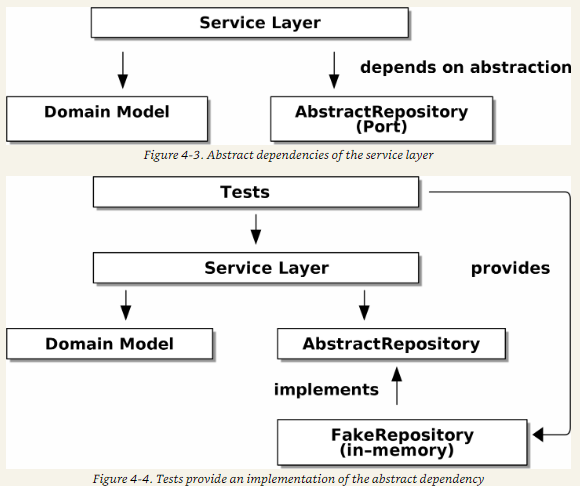

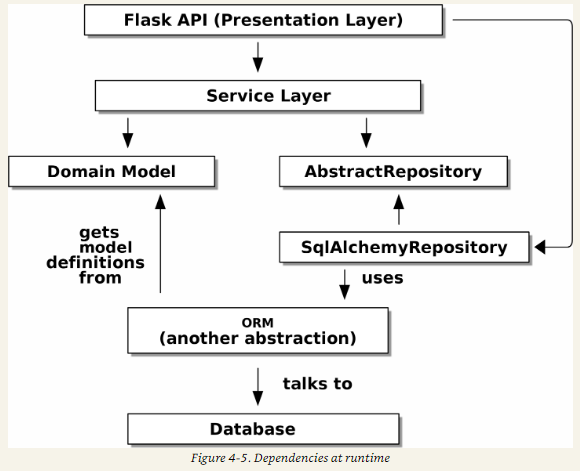